# Telangana Crop Health Challenge
---
###  Can you predict the health status of crops?




---



# Setup Notebook

# Libraries and Modules Import

In [96]:
# Standard Library Imports
from concurrent.futures import ThreadPoolExecutor, as_completed
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import datetime
from pathlib import Path
import os
import random

# Third-Party Imports
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from lightgbm import LGBMClassifier
from shapely.affinity import scale, translate
from skimage import exposure
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

from shapely import wkt
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

import logging
# Set up a logger to capture Rasterio warnings
logging.getLogger("rasterio._env").setLevel(logging.ERROR)

# Project Setup and Earth Engine Initialization

In [97]:
# Define the root path for the project
root_path = Path(os.getcwd())
root_path

WindowsPath('d:/github/telangana-crop-health')

In [98]:
# Authenticate with Google Earth Engine
# This opens a browser prompt for authentication, if not previously authenticated
ee.Authenticate()

project = os.getenv("PROJECT_ID")

# Initialize Earth Engine with a specific project
# Replace "project" with your project ID as needed
ee.Initialize(project=project)

# Data Loading and Preprocessing

**Load Train and Test**

In [99]:
# Load training and testing datasets from CSV files
data_path = root_path / 'telangana_data' / 'data'
train_path = data_path / 'Train.csv'
test_path = data_path / 'Test.csv'
# Load the datasets
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train.shape, test.shape

((7888, 20), (2718, 19))

**Convert Geometry Columns to Geospatial Format**

In [100]:
# Convert WKT geometry to actual geometry objects in both datasets
train['geometry'] = train['geometry'].apply(wkt.loads)
test['geometry'] = test['geometry'].apply(wkt.loads)

**Convert DataFrames to GeoDataFrames**

In [101]:
# Convert pandas DataFrames to GeoDataFrames with CRS set to 'epsg:4326'
train = gpd.GeoDataFrame(train, crs='epsg:4326')
test = gpd.GeoDataFrame(test, crs='epsg:4326')

**Concatenate Train and Test Data for Unified Processing**

In [102]:
# Concatenate train and test datasets into a single DataFrame for consistent processing
# 'dataset' column distinguishes between train and test rows
data = pd.concat(
    [train.assign(dataset='train'), test.assign(dataset='test')]
).reset_index(drop=True)


**Scale Geometry Objects**

In [103]:
# Function to scale each geometry around its centroid
def scale_geometry(geometry, scale_factor):
    """
    Scale a geometry object around its centroid.

    Parameters:
        geometry (shapely.geometry.base.BaseGeometry): Geometry to scale.
        scale_factor (float): Factor by which to scale the geometry.

    Returns:
        shapely.geometry.base.BaseGeometry: Scaled geometry object.
    """
    # Calculate centroid
    centroid = geometry.centroid
    # Translate geometry to origin
    translated_geometry = translate(geometry, -centroid.x, -centroid.y)
    # Scale geometry
    scaled_geometry = scale(translated_geometry, xfact=scale_factor, yfact=scale_factor, origin=(0, 0))
    # Translate back to the original centroid
    return translate(scaled_geometry, centroid.x, centroid.y)

In [104]:
# Set the scaling factor
scale_factor = 5

# Apply the scaling function to each geometry in the data
# This modifies each geometry in place by the defined scale factor
data['geometry'] = data['geometry'].apply(scale_geometry, scale_factor=scale_factor)

# Download Image Data

**Utils**

In [105]:
# Function to ensure date format is correct
def format_date(date_str):
    """Convert date string to 'YYYY-MM-DD' format."""
    formats = ['%d-%m-%Y', '%Y-%m-%d %H:%M:%S']
    for fmt in formats:
        try:
            return datetime.strptime(date_str, fmt).strftime('%Y-%m-%d')
        except ValueError:
            continue
    logging.error(f"Invalid date format for {date_str}. Expected one of {formats}.")
    return None

**Convert GeoDataFrame to Earth Engine FeatureCollection**

In [106]:
# Function to convert a GeoDataFrame to Google Earth Engine FeatureCollection
def gdf_to_gee(gdf):
    """Converts a GeoDataFrame to an Earth Engine FeatureCollection."""
    features = []
    for _, row in gdf.iterrows():
        geom = row['geometry'].__geo_interface__  # Convert geometry to GeoJSON format
        feature = ee.Feature(ee.Geometry(geom), row.to_dict())  # Create an EE Feature
        features.append(feature)
    return ee.FeatureCollection(features)

# Convert the entire dataset GeoDataFrame to a FeatureCollection for GEE
gee_feature_collection = gdf_to_gee(data)

**Initialize Earth Engine and Set Up Directories**

In [107]:
# if you already downloaded the data.
donwload = False

# Initialize Earth Engine
ee.Initialize()

# Remove existing 'downloads' folder if it exists
if os.path.exists('downloads'):
    os.system('rm -rf downloads')

# Ensure the output directory exists
output_folder = 'downloads'
os.makedirs(output_folder, exist_ok=True)

**Download from Earth Engine**

In [108]:
# Function to download RGB images from Earth Engine
def download_rgb_image(collection_name, bands, start_date, end_date, region, output_folder='downloads'):
    """Download RGB bands from a GEE collection filtered by date and region."""
    # Load the image collection, filter by date, and clip to region
    collection = ee.ImageCollection(collection_name).filterDate(start_date, end_date).filterBounds(region)
    image = collection.sort('system:time_start', False).first().select(bands).clip(region)  # Most recent image

    # Define unique filename based on image dates
    image_id = image.id().getInfo() or f'image_{start_date}_{end_date}'
    image_name = f'{output_folder}/{image_id}_RGB_{start_date}_{end_date}.tif'

    # Export the image to a GeoTIFF file
    geemap.ee_export_image(
        image,
        filename=image_name,
        scale=10,  # Sentinel-2 resolution in meters
        region=region,
        file_per_band=False,  # Save as a multi-band TIFF
        crs='EPSG:4326'
    )
    print(f"Downloaded: {image_name}")
    return image_name

In [109]:
# Function to process each row in the dataset for image download
def process_row(index, row):
    # Format start and end dates
    start_date = format_date(row['SDate'])
    end_date = format_date(row['HDate'])

    # Skip rows with invalid dates
    if not start_date or not end_date:
        print(f"Skipping entry due to invalid dates: SDate={row['SDate']}, HDate={row['HDate']}")
        return index, None

    # Extract and check geometry
    region_geometry = row['geometry']
    district = row['District']

    # Verify valid geometry and convert it to EE format
    if region_geometry.is_empty:
        print(f"Skipping entry due to empty geometry for District: {district}")
        return index, None

    # Convert geometry type to EE compatible format
    if region_geometry.geom_type == 'Polygon':
        region = ee.Geometry.Polygon(region_geometry.__geo_interface__['coordinates'])
    elif region_geometry.geom_type == 'MultiPolygon':
        coords = [polygon.exterior.coords[:] for polygon in region_geometry.geoms]
        region = ee.Geometry.MultiPolygon(coords)
    else:
        print(f"Skipping unsupported geometry type: {region_geometry.geom_type} for District: {district}")
        return index, None

    # Define Sentinel-2 collection and bands
    image_collection_name = 'COPERNICUS/S2'
    bands = ['B4', 'B3', 'B2', 'B8', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12']

    # Attempt to download the image
    try:
        image_file = download_rgb_image(image_collection_name, bands, start_date, end_date, region, output_folder)
        return index, image_file
    except Exception as e:
        print(f"Error processing entry for District {district}: {e}")
        return index, None

In [110]:
download = False

if download:
    # Execute image downloads with progress tracking
    with ThreadPoolExecutor(max_workers=40) as executor:
        futures = {executor.submit(process_row, index, row): index for index, row in tqdm(data.iterrows(), total=len(data))}
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Downloading Images"):
            index, image_file = future.result()
            if image_file:
                data.at[index, 'tif_path'] = image_file  # Store the downloaded file path

else:
    # Load existing data with image paths
    os.system('cp -r ./downloads .')
    data_path = "./data.csv"
    
    # Load CSV with progress tracking
    data = pd.read_csv(data_path)
    print("Data loaded successfully.")

Data loaded successfully.


In [111]:
data.to_csv("data.csv", index=False)
data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,CTransp,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,geometry,dataset,tif_path
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25 0:00:00,2024-04-14 0:00:00,97,54,...,Transplanting,Flood,Groundwater,4,87,17,Rabi,POLYGON ((78.18079255482755 17.978971746424413...,train,downloads/20240412T050649_20240412T051727_T43Q...
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13 0:00:00,2024-04-26 0:00:00,82,58,...,Transplanting,Flood,Canal,5,94,15,Rabi,POLYGON ((78.17483419891283 17.981508840879556...,train,downloads/20240425T051649_20240425T052817_T43Q...
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19 0:00:00,2024-04-28 0:00:00,92,91,...,Transplanting,Flood,Canal,3,99,20,Rabi,POLYGON ((78.16888476438905 17.976727511659835...,train,downloads/20240427T050651_20240427T051439_T43Q...
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-02-11 0:00:00,2024-11-04 0:00:00,91,52,...,Transplanting,Flood,Canal,5,92,16,Rabi,POLYGON ((78.16821795882959 17.974690113471414...,train,downloads/20241103T050951_20241103T052004_T43Q...
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-12-12 0:00:00,2024-05-19 0:00:00,94,55,...,Transplanting,Flood,Canal,5,97,20,Rabi,POLYGON ((78.17244459940454 17.969620948965225...,train,downloads/20240517T050651_20240517T051655_T43Q...


# Visualization

In [112]:
data[data['tif_path'].isna()]

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,CTransp,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,geometry,dataset,tif_path
275,1326947,Pests,Cotton,Telangana,Adilabad,Utnur,2023-12-30 0:00:00,2024-01-02 0:00:00,83,84,...,Drilling,Drip,Groundwater,3,58,15,Rabi,"POLYGON ((78.73246144280002 19.39319317878587,...",train,NaN
3482,1330797,Healthy,Chillies,Telangana,Mahabubabad,Gudur,2023-08-10 0:00:00,2023-08-12 0:00:00,57,72,...,Drilling,Sprinkler,Groundwater,3,43,7,Rabi,"POLYGON ((79.97490993827444 17.80467803468922,...",train,NaN
4359,276136,Healthy,Paddy,Telangana,Nalgonda,Kanagal,2023-09-07 0:00:00,2023-09-10 0:00:00,85,86,...,Transplanting,Flood,Groundwater,6,85,25,Kharif,POLYGON ((79.20890754883935 16.977869057972033...,train,NaN
5541,1322898,Healthy,Chillies,Telangana,Mahabubabad,Kuravi,2023-08-22 0:00:00,2023-08-23 0:00:00,47,54,...,Drilling,Drip,Canal,4,48,7,Rabi,POLYGON ((80.08440534583107 17.538877739747743...,train,NaN
5702,1321168,Stressed,Chillies,Telangana,Mahabubabad,Kuravi,2023-12-05 0:00:00,2023-12-06 0:00:00,63,94,...,Drilling,Sprinkler,Rainfed,3,54,10,Rabi,"POLYGON ((80.04098512288914 17.5055150484351, ...",train,NaN
7021,906116,Healthy,Maize,Telangana,Mahabubabad,Gangaram,2023-08-07 0:00:00,2023-08-10 0:00:00,100,175,...,Broadcasting,Drip,Groundwater,2,41,27,Kharif,POLYGON ((80.23777266166059 17.922714813798795...,train,NaN
7103,1308399,Healthy,Maize,Telangana,Mahabubabad,Gangaram,2023-08-07 0:00:00,2023-08-10 0:00:00,88,122,...,Drilling,Drip,Rainfed,2,43,27,Kharif,"POLYGON ((80.20484373846456 17.97677472245114,...",train,NaN
7118,1298442,Healthy,Maize,Telangana,Mahabubabad,Gangaram,2023-08-07 0:00:00,2023-08-11 0:00:00,88,117,...,Broadcasting,Drip,Rainfed,4,54,25,Kharif,POLYGON ((80.28996514956943 17.992834782610142...,train,NaN
8328,1328745,NaN,Cotton,Telangana,Nalgonda,Munugode,2023-12-30 0:00:00,2024-01-03 0:00:00,81,114,...,Drilling,Sprinkler,Canal,6,46,13,Rabi,POLYGON ((78.97839317163441 17.068603232565714...,test,NaN
8982,1314509,NaN,Chillies,Telangana,Mahabubabad,Mahabubabad,2023-01-11 0:00:00,2023-01-13 0:00:00,44,78,...,Drilling,Sprinkler,Canal,4,60,8,Rabi,"POLYGON ((80.05987497758753 17.67215336536132,...",test,NaN


In [113]:
# Function to scale pixel values to the 0–255 range for better visualization
def scale_band(band):
    """
    Scales pixel values of a single band to the 0-255 range.

    Parameters:
    - band: np.array, pixel values of the band

    Returns:
    - np.array, scaled pixel values in the 0-255 range
    """
    band = band.astype(np.float32)  # Ensure values are in float for scaling
    return 255 * (band - np.min(band)) / (np.max(band) - np.min(band))  # Scale to 0–255

# Function to visualize RGB image with scaling, contrast adjustments, and optional gamma correction
def visualize_rgb_image(file_path, gamma=0.6, contrast_stretch=True):
    """
    Visualize an RGB image using matplotlib with scaling, optional gamma correction, and contrast stretching.

    Parameters:
    - file_path: str, path to the RGB image file (GeoTIFF)
    - gamma: float, gamma correction factor (default=0.6)
    - contrast_stretch: bool, whether to apply contrast stretching (default=True)
    """
    # Open the image file
    with rasterio.open(file_path) as src:
        # Read RGB bands (assuming Sentinel-2 band order: Red=B4, Green=B3, Blue=B2)
        red = src.read(3)  # Band 4 for Red
        green = src.read(2)  # Band 3 for Green
        blue = src.read(1)  # Band 2 for Blue

        # Scale each band to the 0–255 range for better visualization
        red_scaled = scale_band(red)
        green_scaled = scale_band(green)
        blue_scaled = scale_band(blue)

        # Stack the scaled RGB bands into a single image
        rgb = np.dstack((red_scaled, green_scaled, blue_scaled)).astype(np.uint8)

        # Apply contrast stretching if specified
        if contrast_stretch:
            p2, p98 = np.percentile(rgb, (2, 98))  # Calculate 2nd and 98th percentiles for stretching
            rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98))

        # Apply gamma correction to adjust brightness
        rgb = exposure.adjust_gamma(rgb, gamma=gamma)

        # Display the processed image using matplotlib
        plt.figure(figsize=(5, 5))
        plt.imshow(rgb)
        plt.axis('off')  # Hide axes for a cleaner look
        plt.title("RGB Composite (Red-Green-Blue) with Scaling, Contrast Stretch, and Gamma Correction")
        plt.show()

    return rgb

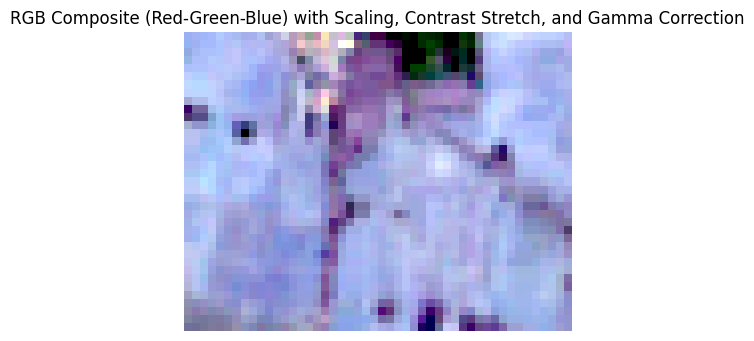

In [114]:
# Select a random image file from the dataset and visualize it
path = random.choice(data['tif_path'].values)
image = visualize_rgb_image(path)

# Feature Engineering

**Utils**

In [115]:
# Example feature calculation functions
def calculate_ndvi(nir_band, red_band):
    """Calculate NDVI (Normalized Difference Vegetation Index)."""
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    return np.nanmean(ndvi)

def calculate_evi(nir_band, red_band, blue_band):
    """Calculate EVI (Enhanced Vegetation Index)."""
    evi = 2.5 * (nir_band - red_band) / (nir_band + 6 * red_band - 7.5 * blue_band + 1)
    return np.nanmean(evi)

def calculate_ndwi(nir_band, green_band):
    """Calculate NDWI (Normalized Difference Water Index)."""
    ndwi = (green_band - nir_band) / (green_band + nir_band)
    return np.nanmean(ndwi)

def calculate_gndvi(nir_band, green_band):
    """Calculate GNDVI (Green Normalized Difference Vegetation Index)."""
    gndvi = (nir_band - green_band) / (nir_band + green_band)
    return np.nanmean(gndvi)

def calculate_savi(nir_band, red_band, L=0.5):
    """Calculate SAVI (Soil Adjusted Vegetation Index)."""
    savi = ((nir_band - red_band) / (nir_band + red_band + L)) * (1 + L)
    return np.nanmean(savi)

def calculate_msavi(nir_band, red_band):
    """Calculate MSAVI (Modified Soil Adjusted Vegetation Index)."""
    msavi = (2 * nir_band + 1 - np.sqrt((2 * nir_band + 1)**2 - 8 * (nir_band - red_band))) / 2
    return np.nanmean(msavi)

In [116]:
import os

# Function to calculate features for each row in the data
def process_row_for_features(index, row):
    features = {'index': index}

    # Retrieve the TIFF file path and check if it's valid
    tif_path = row['tif_path']
    if not isinstance(tif_path, str) or not os.path.exists(tif_path):
        print(f"Skipping entry due to missing or invalid tif_path for index {index}")
        # Add NaN for all features if path is missing
        features.update({
            'ndvi': np.nan,
            'evi': np.nan,
            'ndwi': np.nan,
            'gndvi': np.nan,
            'savi': np.nan,
            'msavi': np.nan
        })
        return features

    # Open the TIFF file and read bands for feature calculation
    try:
        with rasterio.open(tif_path) as src:
            red = src.read(3)    # B4 for Red
            green = src.read(2)  # B3 for Green
            blue = src.read(1)   # B2 for Blue
            nir = src.read(4)    # B8 for NIR

            # Calculate each feature
            features['ndvi'] = calculate_ndvi(nir, red)
            features['evi'] = calculate_evi(nir, red, blue)
            features['ndwi'] = calculate_ndwi(nir, green)
            features['gndvi'] = calculate_gndvi(nir, green)
            features['savi'] = calculate_savi(nir, red)
            features['msavi'] = calculate_msavi(nir, red)
    except rasterio.errors.RasterioIOError as e:
        print(f"Error processing {tif_path}: {e}")
        return {'index': index, 'ndvi': np.nan, 'evi': np.nan, 'ndwi': np.nan, 
                'gndvi': np.nan, 'savi': np.nan, 'msavi': np.nan}

    return features

**Calculate Features**

In [117]:
# Use parallel processing to calculate features for each row
# `tqdm` provides a progress bar to track completion
new_features = Parallel(n_jobs=-1)(delayed(process_row_for_features)(index, row)
                                   for index, row in tqdm(data.iterrows(), total=len(data)))

100%|██████████| 10606/10606 [02:22<00:00, 74.31it/s]


**Merge New Features with Original Data**

In [118]:
# Convert list of features to a DataFrame and merge with the original data
new_features_df = pd.DataFrame(new_features).set_index('index')
data = data.join(new_features_df)

In [119]:
data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,Season,geometry,dataset,tif_path,ndvi,evi,ndwi,gndvi,savi,msavi
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25 0:00:00,2024-04-14 0:00:00,97,54,...,Rabi,POLYGON ((78.18079255482755 17.978971746424413...,train,downloads/20240412T050649_20240412T051727_T43Q...,0.100756,-0.793684,8.488031,0.127153,0.151125,4232.596191
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13 0:00:00,2024-04-26 0:00:00,82,58,...,Rabi,POLYGON ((78.17483419891283 17.981508840879556...,train,downloads/20240425T051649_20240425T052817_T43Q...,0.188090,0.564248,11.493762,0.187815,0.282110,3249.392822
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19 0:00:00,2024-04-28 0:00:00,92,91,...,Rabi,POLYGON ((78.16888476438905 17.976727511659835...,train,downloads/20240427T050651_20240427T051439_T43Q...,0.206596,-1.456745,10.166884,0.206553,0.309869,3741.956055
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-02-11 0:00:00,2024-11-04 0:00:00,91,52,...,Rabi,POLYGON ((78.16821795882959 17.974690113471414...,train,downloads/20241103T050951_20241103T052004_T43Q...,0.206250,2.206184,10.446196,0.220995,0.309350,3673.396729
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-12-12 0:00:00,2024-05-19 0:00:00,94,55,...,Rabi,POLYGON ((78.17244459940454 17.969620948965225...,train,downloads/20240517T050651_20240517T051655_T43Q...,0.179721,-0.743638,8.665929,0.160657,0.269563,4227.338379


**Split Dataset into Train and Test**

In [120]:
# Split the data into train and test sets based on the 'dataset' column
train = data[data.dataset == 'train'].reset_index(drop=True)
test = data[data.dataset == 'test'].reset_index(drop=True)

In [121]:
# Define columns to drop before encoding and training
to_drop = [
    'geometry', 'tif_path',  # Spatial and file path information
]

# Drop the specified columns from train and test sets
train.drop(columns=to_drop, inplace=True)
test.drop(columns=to_drop, inplace=True)


In [122]:
# Concatenate train and test datasets for uniform encoding of categorical columns
data_combined = pd.concat([train, test], ignore_index=True)

In [123]:
# Create a mapping for the target variable 'category' to numeric labels, excluding NaN values
category_mapper = {label: idx for idx, label in enumerate(data_combined['category'].unique()) if pd.notna(label)}
idx_to_category_mapper = {idx: label for idx, label in enumerate(data_combined['category'].unique()) if pd.notna(label)}

# Map the 'category' column to the new 'target' column using the mapping, handling NaN values as needed
data_combined['target'] = data_combined['category'].map(category_mapper)

# Drop the original 'category' column now that we have the 'target' column
data_combined.drop(columns=['category'], inplace=True)

In [124]:
# Identify categorical columns to encode
categorical_cols = data_combined.select_dtypes(include=['object']).columns

# Apply Label Encoding for all categorical columns
for col in categorical_cols:
    encoder = LabelEncoder()
    data_combined[col] = encoder.fit_transform(data_combined[col])

In [125]:
data_combined

,FarmID,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,CNext,...,ExpYield,Season,dataset,ndvi,evi,ndwi,gndvi,savi,msavi,target
0,1326576,5,0,6,75,299,311,97,54,4,...,17,1,1,0.100756,-0.793684,8.488031,0.127153,0.151125,4232.596191,0.0
1,1326577,5,0,6,75,287,323,82,58,4,...,15,1,1,0.188090,0.564248,11.493762,0.187815,0.282110,3249.392822,0.0
2,1326578,5,0,6,75,322,325,92,91,4,...,20,1,1,0.206596,-1.456745,10.166884,0.206553,0.309869,3741.956055,0.0
3,1331836,5,0,6,75,32,491,91,52,4,...,16,1,1,0.206250,2.206184,10.446196,0.220995,0.309350,3673.396729,1.0
4,1326579,5,0,6,75,315,343,94,55,4,...,20,1,1,0.179721,-0.743638,8.665929,0.160657,0.269563,4227.338379,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10601,551119,4,0,10,126,255,381,92,225,10,...,39,1,0,0.238710,3.679797,5.589317,0.037121,0.358050,5999.669434,NaN
10602,916476,4,0,10,126,113,304,79,236,7,...,40,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10603,121860,4,0,10,126,288,274,87,210,10,...,41,1,0,0.171067,0.772799,12.381079,0.197460,0.256577,3089.120361,NaN
10604,270936,4,0,10,126,33,296,95,204,10,...,39,1,0,0.247241,-0.057281,10.578072,0.261666,0.370831,3743.854980,NaN


In [137]:
# Split the combined encoded data back into train and test
train_encoded = data_combined[data_combined.dataset == 1].reset_index(drop=True)
test_encoded = data_combined[data_combined.dataset == 0].reset_index(drop=True)

# Model Training

In [127]:
test_encoded.columns

Index(['FarmID', 'Crop', 'State', 'District', 'Sub-District', 'SDate', 'HDate',
       'CropCoveredArea', 'CHeight', 'CNext', 'CLast', 'CTransp', 'IrriType',
       'IrriSource', 'IrriCount', 'WaterCov', 'ExpYield', 'Season', 'dataset',
       'ndvi', 'evi', 'ndwi', 'gndvi', 'savi', 'msavi', 'target'],
      dtype='object')

In [128]:
# Separate features and target variable in the train set
X = train_encoded.drop(columns=['FarmID', 'dataset', 'target'])
y = train_encoded['target'].astype(int)

In [129]:
# Stratified split based on 'target' for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [130]:
# Configuration dictionary for LightGBM parameters
config_dict = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': len(category_mapper),  # Number of classes in the target
    'num_leaves': 81,
    'learning_rate': 0.01,
    'n_estimators': 500,
    'random_state': 42,
    'force_row_wise': 'true',
    'imbalance': 'true',
}

# Initialize LightGBM classifier with config_dict parameters
model = LGBMClassifier(**config_dict)

# Fit the model with an evaluation set for early stopping and progress tracking
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
)

[LightGBM] [Warning] Unknown parameter: imbalance
[LightGBM] [Warning] Unknown parameter: imbalance
[LightGBM] [Info] Total Bins 2592
[LightGBM] [Info] Number of data points in the train set: 6310, number of used features: 22
[LightGBM] [Warning] Unknown parameter: imbalance
[LightGBM] [Info] Start training from score -0.192516
[LightGBM] [Info] Start training from score -2.812355
[LightGBM] [Info] Start training from score -2.788886
[LightGBM] [Info] Start training from score -2.926845


LGBMClassifier(force_row_wise='true', imbalance='true', learning_rate=0.01,
               metric='multi_logloss', n_estimators=500, num_class=4,
               num_leaves=81, objective='multiclass', random_state=42)

In [131]:
# Predict on the validation set
y_pred = model.predict(X_valid)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

[LightGBM] [Warning] Unknown parameter: imbalance
Classification Report:
               precision    recall  f1-score   support

     Healthy       0.82      1.00      0.90      1301
    Diseased       0.00      0.00      0.00        95
       Pests       0.00      0.00      0.00        97
    Stressed       0.00      0.00      0.00        85

    accuracy                           0.82      1578
   macro avg       0.21      0.25      0.23      1578
weighted avg       0.68      0.82      0.74      1578


Weighted F1 Score: 0.7438792086846311


 # Submit

In [132]:
test_encoded.columns

Index(['FarmID', 'Crop', 'State', 'District', 'Sub-District', 'SDate', 'HDate',
       'CropCoveredArea', 'CHeight', 'CNext', 'CLast', 'CTransp', 'IrriType',
       'IrriSource', 'IrriCount', 'WaterCov', 'ExpYield', 'Season', 'dataset',
       'ndvi', 'evi', 'ndwi', 'gndvi', 'savi', 'msavi', 'target'],
      dtype='object')

In [133]:
test_encoded

,FarmID,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,CNext,...,ExpYield,Season,dataset,ndvi,evi,ndwi,gndvi,savi,msavi,target
0,85197,5,0,6,116,286,338,81,99,0,...,19,1,0,0.164242,-1.044359,9.219643,0.163744,0.246346,3983.870605,NaN
1,779677,5,0,6,116,323,352,91,63,0,...,15,1,0,0.031936,-1.071136,6.664450,0.052519,0.047902,5052.938477,NaN
2,1331840,5,0,6,116,303,342,94,89,4,...,15,1,0,0.085994,-0.522534,8.151046,0.098604,0.128983,4407.772949,NaN
3,483053,5,0,6,116,6,324,83,78,4,...,17,1,0,0.206187,1.184240,10.467062,0.215879,0.309255,3654.566650,NaN
4,542945,5,0,6,116,83,322,82,53,0,...,18,1,0,0.211586,-0.400884,10.138931,0.218611,0.317355,3775.530273,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713,551119,4,0,10,126,255,381,92,225,10,...,39,1,0,0.238710,3.679797,5.589317,0.037121,0.358050,5999.669434,NaN
2714,916476,4,0,10,126,113,304,79,236,7,...,40,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2715,121860,4,0,10,126,288,274,87,210,10,...,41,1,0,0.171067,0.772799,12.381079,0.197460,0.256577,3089.120361,NaN
2716,270936,4,0,10,126,33,296,95,204,10,...,39,1,0,0.247241,-0.057281,10.578072,0.261666,0.370831,3743.854980,NaN


In [134]:
test_encoded

,FarmID,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,CNext,...,ExpYield,Season,dataset,ndvi,evi,ndwi,gndvi,savi,msavi,target
0,85197,5,0,6,116,286,338,81,99,0,...,19,1,0,0.164242,-1.044359,9.219643,0.163744,0.246346,3983.870605,NaN
1,779677,5,0,6,116,323,352,91,63,0,...,15,1,0,0.031936,-1.071136,6.664450,0.052519,0.047902,5052.938477,NaN
2,1331840,5,0,6,116,303,342,94,89,4,...,15,1,0,0.085994,-0.522534,8.151046,0.098604,0.128983,4407.772949,NaN
3,483053,5,0,6,116,6,324,83,78,4,...,17,1,0,0.206187,1.184240,10.467062,0.215879,0.309255,3654.566650,NaN
4,542945,5,0,6,116,83,322,82,53,0,...,18,1,0,0.211586,-0.400884,10.138931,0.218611,0.317355,3775.530273,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713,551119,4,0,10,126,255,381,92,225,10,...,39,1,0,0.238710,3.679797,5.589317,0.037121,0.358050,5999.669434,NaN
2714,916476,4,0,10,126,113,304,79,236,7,...,40,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2715,121860,4,0,10,126,288,274,87,210,10,...,41,1,0,0.171067,0.772799,12.381079,0.197460,0.256577,3089.120361,NaN
2716,270936,4,0,10,126,33,296,95,204,10,...,39,1,0,0.247241,-0.057281,10.578072,0.261666,0.370831,3743.854980,NaN


In [139]:
# Load submission file
import polars as pl
sample_submission = pl.read_csv(root_path / 'telangana_data' / 'data' / "SampleSubmission.csv")

# Predict on the test set
test_encoded['target'] = model.predict(test_encoded.drop(columns=['FarmID', 'dataset', 'target']))  # Drop 'FarmID' if it exists in test_encoded
test_encoded['target'] = test_encoded['target'].astype(int).map(idx_to_category_mapper)
test_encoded_pl = pl.from_pandas(test_encoded)

sample_submission = sample_submission.join(test_encoded_pl, left_on='ID', right_on='FarmID').select(['ID', 'target'])

[LightGBM] [Warning] Unknown parameter: imbalance


In [145]:
sample_submission = sample_submission.rename({'ID': 'ID', 'target': 'Target'})
sample_submission.write_csv('submission.csv')
sample_submission.head()

ID,Target
i64,str
85197,"""Healthy"""
779677,"""Healthy"""
1331840,"""Healthy"""
483053,"""Healthy"""
542945,"""Healthy"""


In [146]:
sample_submission.filter(pl.col('ID')==1328197)

ID,Target
i64,str
1328197,"""Healthy"""
